# Dogs vs. Cats Image Classification Using Convolutional Neural Networks (InceptionResNetV2)¶

Download the Dogs vs Cats image catalog from Kaggle here : https://www.kaggle.com/competitions/dogs-vs-cats/data

Follow the steps below:

## Dataset

Unzip the dataset in your downloads folder as shown in the image below:

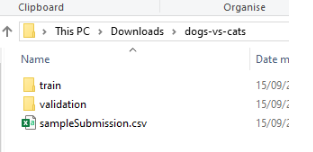

## Imports

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, SGD
import seaborn as sns
import pandas as pd
import shutil
import random

In [5]:
data_dir = 'C:\\Users\\jordi\\Downloads\\dogs-vs-cats'
train_dir = os.path.join(data_dir, 'Train')
validation_dir = os.path.join(data_dir, 'Validation')

## Copy images to a local directory

In [6]:
# local directory `data`
base_dir = 'data'  
train_dir_new = os.path.join(base_dir, 'train')
os.makedirs(train_dir_new, exist_ok=True)

train_cats_dir = os.path.join(train_dir_new, 'cats')
train_dogs_dir = os.path.join(train_dir_new, 'dogs')
os.makedirs(train_cats_dir, exist_ok=True)
os.makedirs(train_dogs_dir, exist_ok=True)

all_images = os.listdir(train_dir)

cat_images = [img for img in all_images if img.startswith('cat')]
dog_images = [img for img in all_images if img.startswith('dog')]

def copy_images(image_list, source_dir, dest_dir):
    for img in image_list:
        src = os.path.join(source_dir, img)
        dst = os.path.join(dest_dir, img)
        shutil.copyfile(src, dst)

copy_images(cat_images, train_dir, train_cats_dir)
copy_images(dog_images, train_dir, train_dogs_dir)

## Geneare Training and Validation data split 70/30

In [8]:
train_cats, val_cats = train_test_split(os.listdir(train_cats_dir), test_size=0.3, random_state=42)
train_dogs, val_dogs = train_test_split(os.listdir(train_dogs_dir), test_size=0.3, random_state=42)

validation_dir_new = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir_new, exist_ok=True)
validation_cats_dir = os.path.join(validation_dir_new, 'cats')
validation_dogs_dir = os.path.join(validation_dir_new, 'dogs')
os.makedirs(validation_cats_dir, exist_ok=True)
os.makedirs(validation_dogs_dir, exist_ok=True)

def move_images(image_list, source_dir, dest_dir):
    for img in image_list:
        src = os.path.join(source_dir, img)
        dst = os.path.join(dest_dir, img)
        shutil.move(src, dst)

move_images(val_cats, train_cats_dir, validation_cats_dir)
move_images(val_dogs, train_dogs_dir, validation_dogs_dir)

## Create ImageDataGenerators

In [9]:
test_dir = validation_dir  

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=10,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [11]:
image_size = (299, 299)
batch_size = 8
epochs = 100

train_generator = train_datagen.flow_from_directory(
    train_dir_new,
    target_size=image_size,
    batch_size=batch_size,
    interpolation='bicubic',
    class_mode='categorical', 
    classes=['cats', 'dogs']
)

# Validation generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir_new,
    target_size=image_size,
    batch_size=batch_size,
    interpolation='bicubic',
    class_mode='categorical', 
    classes=['cats', 'dogs'], 
)

for cls, idx in train_generator.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Class #0 = cats
Class #1 = dogs


## Show the content of the generators

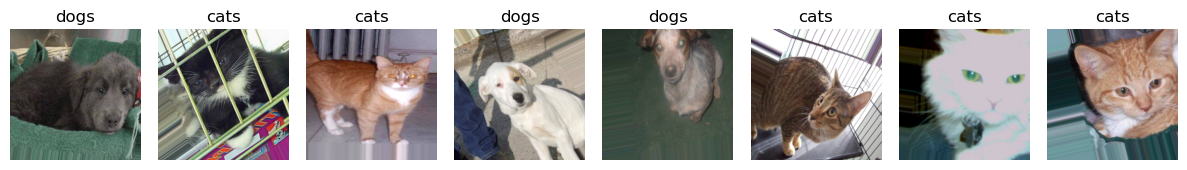

In [17]:
import matplotlib.pyplot as plt
import numpy as np

images_batch, labels_batch = next(train_generator)

labels_indices = np.argmax(labels_batch, axis=1)

class_indices = train_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

def inverse_preprocess_input(x):
    x = x + 1.0  
    x = x * 127.5  
    x = np.clip(x, 0, 255)
    return x.astype('uint8')

plt.figure(figsize=(12, 12))
num_images = min(64, images_batch.shape[0])  
for i in range(num_images):
    plt.subplot(8, 8, i + 1)
    img = images_batch[i]
    img = inverse_preprocess_input(img)
    plt.imshow(img)
    label_index = labels_indices[i]
    label_name = index_to_class[label_index]
    plt.title(label_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Build the test generator

In [19]:
test_images = os.listdir(test_dir)
test_images = [img for img in test_images if img.endswith('.jpg')]

# Create a DataFrame
test_df = pd.DataFrame({'filename': test_images})

# Create test data generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='filename',
    y_col=None,  
    target_size=image_size,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

Found 12500 validated image filenames.


## Build the Training Model

In [33]:
# Load the pre-trained InceptionResNetV2 model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=None, input_shape=(299, 299, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(2, activation='softmax', name='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

defined_metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
]

sgd = SGD(learning_rate=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
print('Configuration Start -------------------------')
print(sgd.get_config())
print('Configuration End -------------------------')

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=defined_metrics)
print(model.summary())

Configuration Start -------------------------
{'name': 'SGD', 'learning_rate': 1e-05, 'decay': 1e-06, 'momentum': 0.9, 'nesterov': True}
Configuration End -------------------------
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1218 (Conv2D)           (None, 149, 149, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_nor

## Train the model

In [34]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model_resnet_v2.h5',
    monitor='val_accuracy',
    save_best_only=True
)


history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
2187/2187 [==============================] - 657s 295ms/step - loss: 0.3957 - accuracy: 0.8415 - precision: 0.8415 - recall: 0.8415 - auc: 0.9223 - val_loss: 0.1940 - val_accuracy: 0.9851 - val_precision: 0.9851 - val_recall: 0.9851 - val_auc: 0.9962
Epoch 2/100
2187/2187 [==============================] - 645s 295ms/step - loss: 0.1754 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9909 - val_loss: 0.1190 - val_accuracy: 0.9887 - val_precision: 0.9887 - val_recall: 0.9887 - val_auc: 0.9973
Epoch 3/100
2187/2187 [==============================] - 647s 296ms/step - loss: 0.1257 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9938 - val_loss: 0.0906 - val_accuracy: 0.9888 - val_precision: 0.9888 - val_recall: 0.9888 - val_auc: 0.9978
Epoch 4/100
2187/2187 [==============================] - 646s 295ms/step - loss: 0.1025 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9952 - val_loss: 0.0753 - val_accuracy: 0.9891 - val_preci

plotting metrics


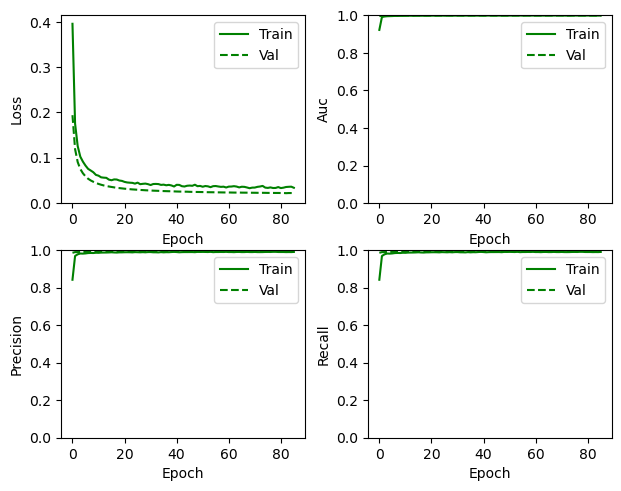

plotting accuracy


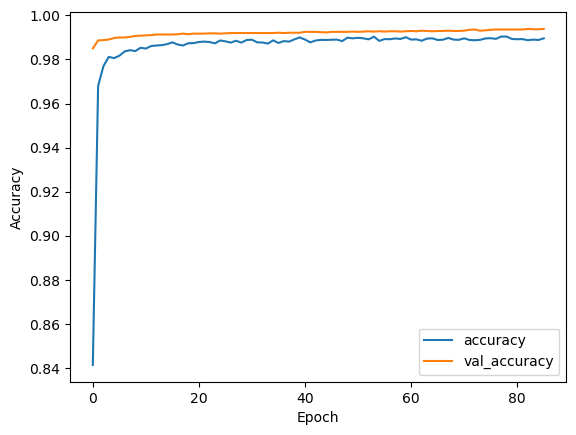

In [35]:
from advance_plotting import Plotter

class_names = ['cat', 'dog']
plotter = Plotter(class_names)
print("plotting metrics")
plotter.plot_metrics(history, os.path.join('metrics', 'plot1.png'), 2)

print("plotting accuracy")
plotter.plot_accuracy(history, os.path.join('metrics', 'plot2.png'))

In [36]:
model.load_weights('best_model_resnet_v2.h5')

# Evaluate on validation data
baseline_results = model.evaluate(validation_generator)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

938/938 [==============================] - 124s 132ms/step - loss: 0.0221 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9993
loss :  0.022075723856687546
accuracy :  0.9937333464622498
precision :  0.9937333464622498
recall :  0.9937333464622498
auc :  0.9992535710334778



## Testing our Model to predict images

In [88]:
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples)

12500/12500 [==============================] - 698s 56ms/step


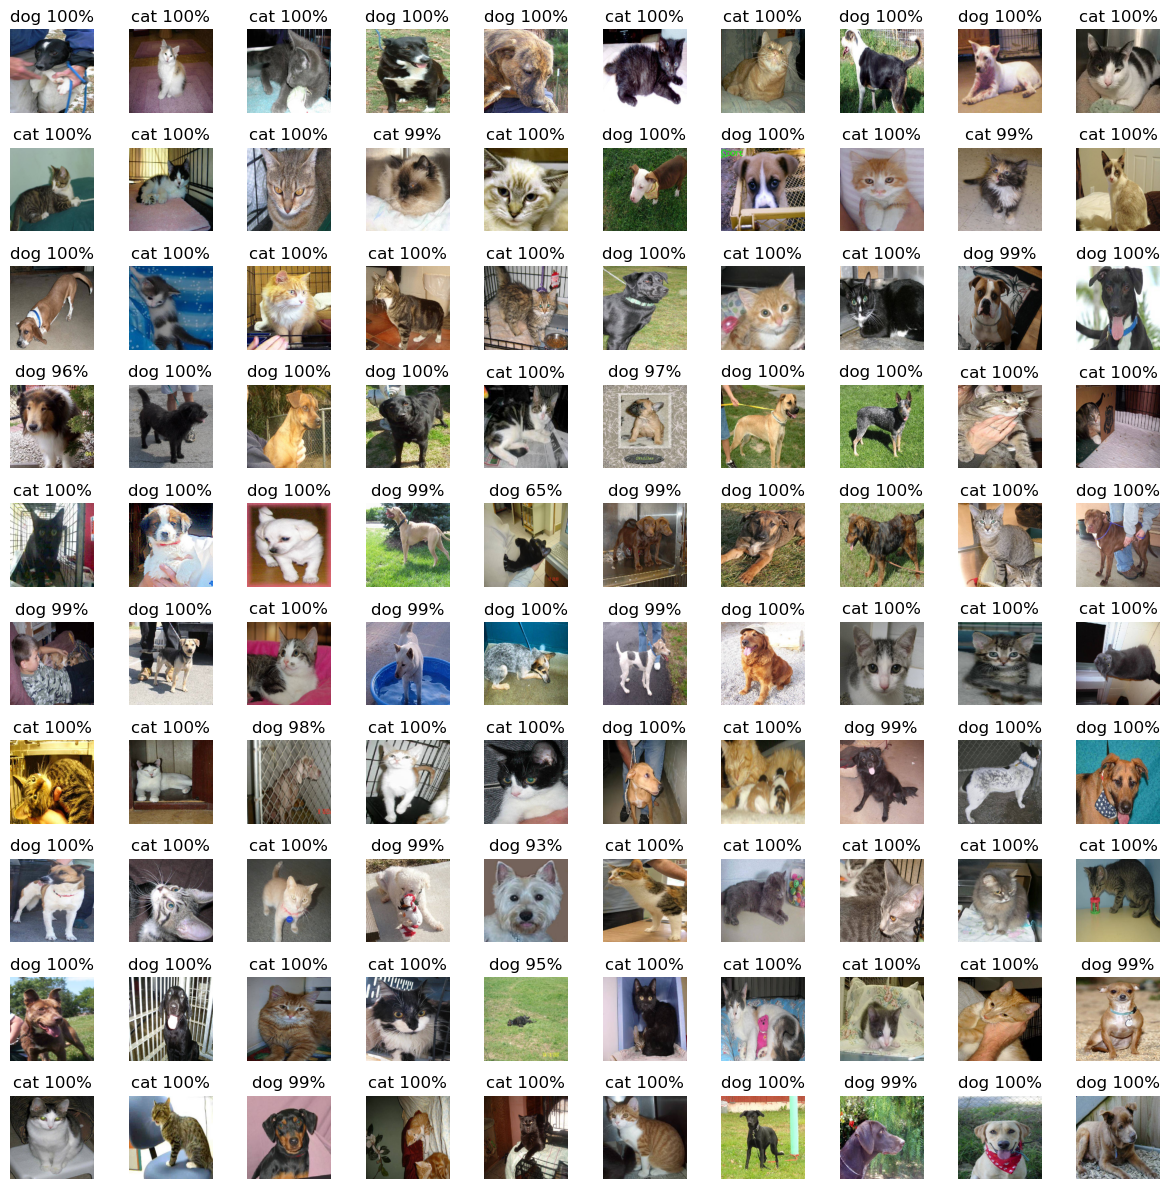

In [89]:
def plot_test_predictions(generator, predictions, num_samples=100):
    plt.figure(figsize=(12, 12))
    for i in range(num_samples):
        plt.subplot(10, 10, i+1)
        img_path = os.path.join(generator.directory, generator.filenames[i])
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=generator.target_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array.astype(np.uint8)
        plt.imshow(img_array)

        predicted_label = '??'
        if predictions[i][0] > 0.5:
            formatted_number = "{:.0%}".format(predictions[i][0])
            predicted_label = f'cat {formatted_number}'
        elif predictions[i][1] > 0.5:
            formatted_number = "{:.0%}".format(predictions[i][1])
            predicted_label = f'dog {formatted_number}'
        
        plt.title(f'{predicted_label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_test_predictions(test_generator, predictions)

## Predict external images

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
import matplotlib.pyplot as plt

def predict_images_in_folder(folder_path, model_path):
    model = load_model(model_path)

    class_labels = ['cats', 'dogs']

    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                   if os.path.isfile(os.path.join(folder_path, f)) and
                   os.path.splitext(f)[1].lower() in valid_extensions]

    for img_path in image_files:
        try:
            img = image.load_img(img_path, target_size=(299, 299))
            x = image.img_to_array(img)
            x_processed = preprocess_input(x)
            x_processed = np.expand_dims(x_processed, axis=0)
            preds = model.predict(x_processed)
            predicted_class_index = np.argmax(preds[0])
            predicted_class_label = class_labels[predicted_class_index]
            probability = preds[0][predicted_class_index]
            formatted_prob = "{:.2%}".format(probability)
            print(f"Image: {img_path}")
            print(f"Predicted: {predicted_class_label} ({formatted_prob})")
            plt.imshow(img)
            plt.title(f"Predicted: {predicted_class_label} ({formatted_prob})")
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

folder_path = r'c:\temp\dogs'  
model_path = 'best_model_resnet_v2.h5'

predict_images_in_folder(folder_path, model_path)